In [101]:
import numpy as np
import scipy
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

import seaborn as sns
#sns.set_style('white')
#sns.set_style('ticks')
#sns.set_context('notebook')

import h5py
import allel
import EnrichRLib as erl
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Project settings
from os.path import join 
WORKDIR = '/home/sergio/Res_CIML/TLX3_project'
SCRIPTS = join(WORKDIR,'scripts')
DATADIR = join(WORKDIR,'data')

In [5]:
# DATA loading
import pybedtools as pb

WES = 'tracks/WGS-WES/Exomes'
WGS = 'tracks/WGS-WES/Germline'
ISEC = 'tracks/WGS-WES/IntSect'

In [6]:
# Exome vcf
tlx_ex = pb.BedTool(join(DATADIR,WES,'WES_TLX3.vcf.gz'))
tap_ex = pb.BedTool(join(DATADIR,WES,'WES_TAP.vcf.gz'))
tum7_ex = pb.BedTool(join(DATADIR,WES,'WES_Tumor7.vcf.gz'))
tum8_ex = pb.BedTool(join(DATADIR,WES,'WES_Tumor8.vcf.gz'))

# Genome vcf
tlx_gn = pb.BedTool(join(DATADIR,WGS,'TLX3_WGS.vcf.gz'))
tap_gn = pb.BedTool(join(DATADIR,WGS,'TAP_WGS.vcf.gz'))

# Intersection 
tlxe_isec = pb.BedTool(join(DATADIR,ISEC,'isec_WES_TLX3.vcf'))
tape_isec = pb.BedTool(join(DATADIR,ISEC,'isec_WES_TAP.vcf'))
tum7e_isec = pb.BedTool(join(DATADIR,ISEC,'isec_WES_Tumor7.vcf'))
tum8e_isec = pb.BedTool(join(DATADIR,ISEC,'isec_WES_Tumor8.vcf'))
                            
tlxg_isec = pb.BedTool(join(DATADIR,ISEC,'isec_TLX3_WGS.vcf'))
tapg_isec = pb.BedTool(join(DATADIR,ISEC,'isec_TAP_WGS.vcf'))



# Common mutation across samples

In [7]:
## Read VCF from intesection
# variants data to DataFrame, transform SNPEFF to separated fields (optional)
var_isec = allel.vcf_to_dataframe(tlxg_isec.fn,fields='*', numbers={'ALT': 2}, transformers=allel.ANNTransformer())


In [8]:
cod_var_isec = var_isec[var_isec['ANN_Feature_Type']=='transcript']
cod_var_isec.loc[:,'ANN_Gene_Name'] = cod_var_isec.loc[:,'ANN_Gene_Name'].str.upper()


In [9]:
print('Number mutation in all = ', len(var_isec))
print('Number mutation in all in genes = ', len(cod_var_isec))

Number mutation in all =  1198
Number mutation in all in genes =  1001


# Frequency muatations on mutated genes 

Text(0.5,1,'Number of mutation on genes muated in all samples')

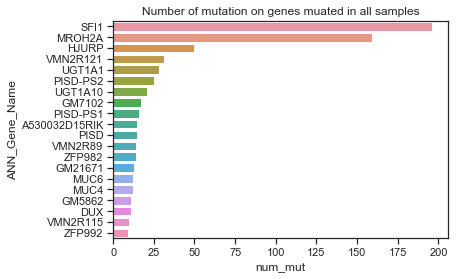

In [10]:
freq = cod_var_isec[['ANN_Gene_Name']]
freq['num_mut'] = 1
freqq = freq.groupby('ANN_Gene_Name').sum()
freqq.sort_values('num_mut', axis=0, inplace=True, ascending=False)

freq_hd = freqq.head(20)

f, ax = plt.subplots()
sns.barplot(y=freq_hd.index,
            x='num_mut',
            ax= ax,
           data= freq_hd)
ax.set_title('Number of mutation on genes muated in all samples')

# Enrichment of mutated genes

In [11]:
gn_mut=list(cod_var_isec['ANN_Gene_Name'].unique())


In [12]:
print('Number of mutated genes in all = ',len(gn_mut))

Number of mutated genes in all =  192


In [13]:
# List of gene sets as above
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016'
       ]

enr_mut = erl.enrich_gs(gn_mut,gss, path_lib=join(DATADIR,'EnrichrLibs'))

GO_Biological_Process_2018 860
GO_Cellular_Component_2018 114
GO_Molecular_Function_2018 183
KEGG_2016 173
Reactome_2016 459


Text(0.5,1,'Genes muated in all samples')

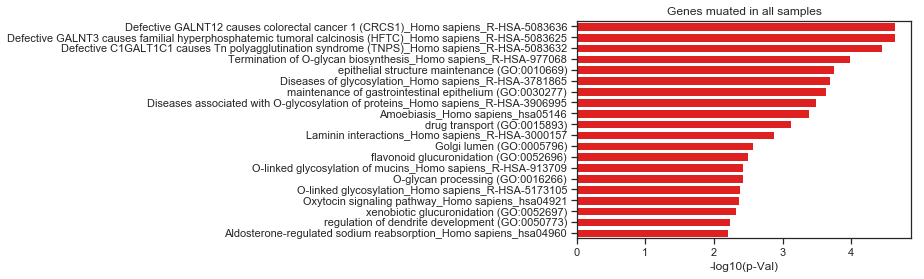

In [14]:
# --- Plot ---
enr_mut.sort_values('p-Val', axis=0, inplace = True)
ds = enr_mut.head(20)

f, ax = plt.subplots()
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            color="Red", 
            data = ds)
ax.set_title('Genes muated in all samples')

# Expression of mutated genes across samples

In [15]:
import RNA_expression_processing as rn
tbl = pd.read_table(join(DATADIR,'tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

# === Pheno ==
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3


cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
tbv = tbn.set_index(keys=tbn.columns[0])
tbv.index=tbv.index.str.upper()


Text(0.5,1,'Cluster TLX3/RAG')

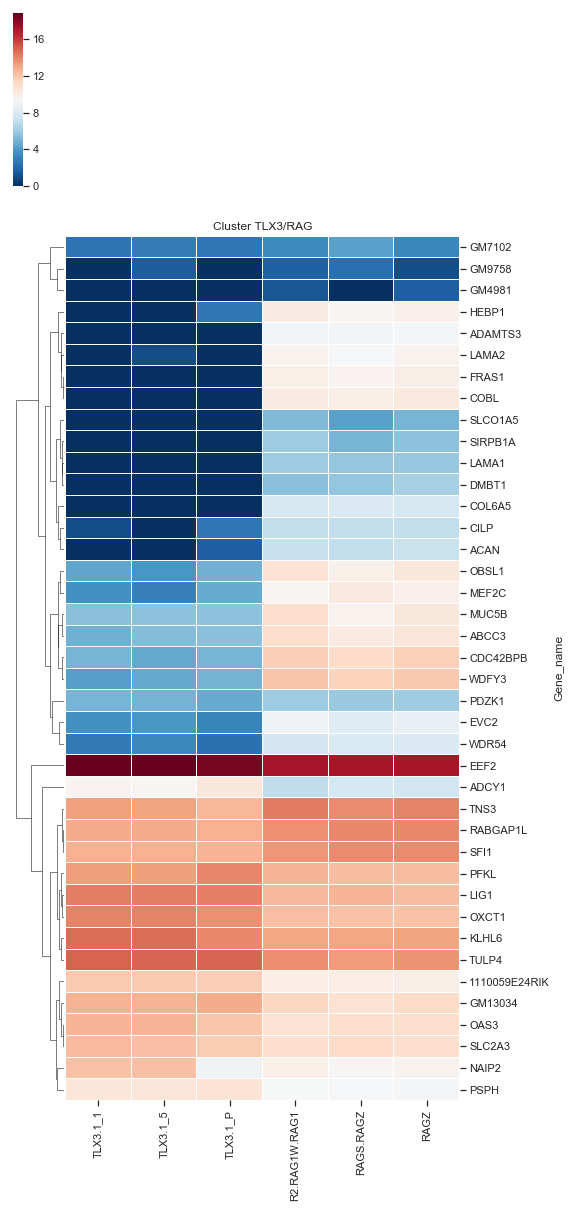

In [18]:
ntop=40
tbmut = tbv.iloc[tbv.index.isin(gn_mut)]
gr = rn.cluster(tbmut, A, B, classes, n_top=ntop)
gr.ax_heatmap.set_title('Cluster '+A+'/'+B)

# Oncogenes from *CancerMine* and *COSMIC*

**CancerMine** is a literature-mined database of drivers, oncogenes and tumor suppressors in cancer. It is a valuable resource for cancer researchers and clinicians to understand the genetic underpinnings of different cancer types. The largest bottleneck in precision oncology is interpreting the myriad of mutations found in individual patient tumors. Knowledge of the role of those genes in cancer is essential. This resource provides information on genes that are drivers (frequently harbor cancer-promoting mutations), oncogenes (cancer-promoting) and tumor suppressors (protective against cancer) in a large number of different cancers. Context is key as some genes (e.g. NOTCH1) are oncogenes in one cancer and tumor suppressive in another. All data has been text-mined from articles and the source sentence and links are provided.

**COSMIC**, the Catalogue Of Somatic Mutations In Cancer, is the world's largest and most comprehensive resource for exploring the impact of somatic mutations in human cancer.

In [19]:
# Load T-ALL ocnogenes
tall = erl.read_gmt(join(DATADIR,'gene_lists/Cancermine/T-ALL.gmt')) 
df_mut = pd.read_csv(join(DATADIR,'gene_lists/COSMIC/Genes_mutation_HUMAN_Acute-lymphoblastic-leukaemia.csv'))

df_mut['Gname'] = df_mut['Gene name'].apply(lambda x: x.split('_')[0])

tall_onc = tall['T-ALL all']
tall_mut = list(df_mut['Gname'].unique())

In [22]:
print('Genes mutated in T-ALL = ',len(tall_mut))
print('Genes oncogenes in T-ALL = ',len(tall_onc))

Genes mutated in T-ALL =  497
Genes oncogenes in T-ALL =  103


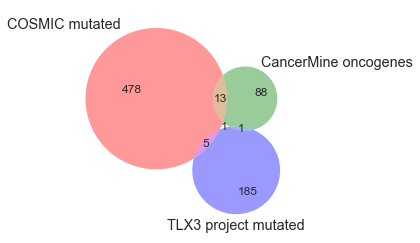

In [23]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3


venn3([set(tall_mut), set(tall_onc), set(gn_mut)], 
      set_labels = ('COSMIC mutated', 'CancerMine oncogenes', 'TLX3 project mutated'))


### Gene in all three groups  -- KRAS

In [24]:
uniq = set(gn_mut)&set(tall_mut)&set(tall_onc)
print('Gene in all sets: ', uniq)

Gene in all sets:  {'KRAS'}


### Genes in COSMIC and TLX3-project mutated 

In [25]:
cos_tlx3 = set(gn_mut)&set(tall_mut)
print('Gene in COSMIC and TLX3-project mutated: ', list(cos_tlx3))

Gene in COSMIC and TLX3-project mutated:  ['KRAS', 'MUC4', 'EEF2', 'MUC5B', 'MID1', 'VCL']


# Expression analysis of all three sets

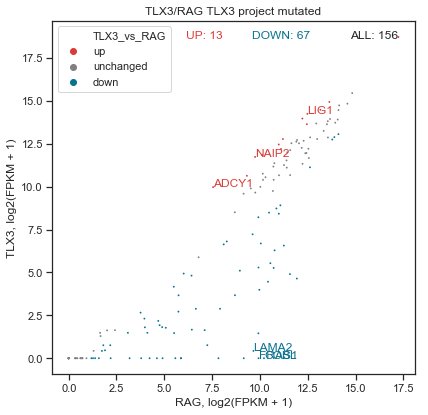

In [26]:
tbmut = tbv.iloc[tbv.index.isin(gn_mut)]
jj,kk,ll=rn.scatter_n(tbmut, A, B, classes, n_top=3, ttl='TLX3 project mutated') 

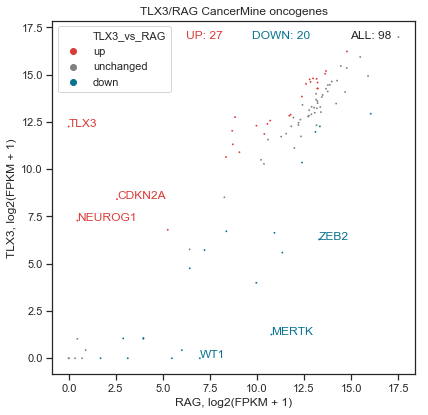

In [27]:
jj,kk,ll=rn.scatter_n(tbv.iloc[tbv.index.isin(tall_onc)], 
                      A, B, classes, n_top=3, 
                      ttl='CancerMine oncogenes') 

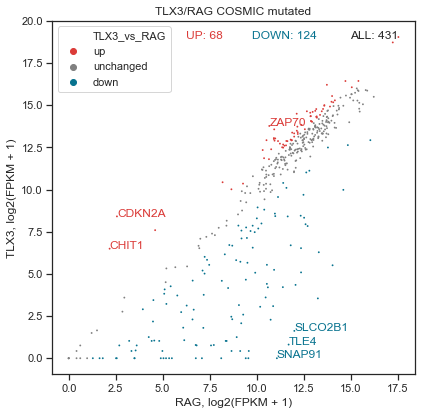

In [28]:
jj,kk,ll=rn.scatter_n(tbv.iloc[tbv.index.isin(tall_mut)], 
                      A, B, classes, n_top=3, 
                      ttl='COSMIC mutated') 

# Gene list mutation

In [55]:
genes_b = pb.BedTool(join(DATADIR,'tracks/annot_tracks/references/mm9/mm9.refGene.bed'))


In [30]:
def gene_variants(gl,var,genes):
    """
    gl - genes list
    var - variant DataFrame; ex. var = allel.vcf_to_dataframe('fn.vcf')
    genes - bed with genes; ex. genes = pb.BedTool('genes.bed')
    """
    genes = genes.to_dataframe()
    genes.loc[:,'name'] = genes.loc[:,'name'].str.upper()
    genes_l = genes[genes['name'].isin(gl)]
    
    var_gl = pd.DataFrame()
    for idx, row in genes_l.iterrows():
        vg = var[(var['CHROM']==row['chrom']) & (var['POS']>row['start']) & (var['POS']<row['end'])]
        genes_l.loc[idx,'num_mut'] = int(len(vg))
        var_gl = pd.concat([var_gl, vg])
    return  var_gl, genes_l

In [54]:
def bed_variants(var,bed):
    """
    Function colect variants in region bed file and out to variants file
    
    Parametrs
    ---------
    var : variant bed file; ex. var = pb.BedTool('fn.vcf')
    bed : bed file with regions; ex. bed = pb.BedTool('genes.bed')
    """
    var_out = var.intersect(bed, header=True)
    
    return  var_out

def variants_bed_counts(var,bed):
    """
    Function counts variants in region bed file
    
    Parametrs
    ---------
    var : variant bed file; ex. var = pb.BedTool('fn.vcf')
    bed : bed file with regions; ex. bed = pb.BedTool('genes.bed')
    
    Output
    ------
    bed_out : bed with last 'counts' column 
    """
    bed_out = bed.intersect(var, c=True)

    return bed_out

In [32]:
vt, bt = bed_variants(var_isec,genes_b)

#vd, gfl = gene_variants(tall_onc,var_isec,genes_b)
#vd.head()

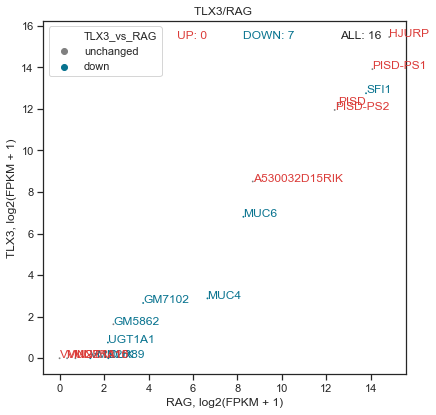

In [49]:
#freq_hd
tbmut = tbv.iloc[tbv.index.isin(freq_hd.index)]
gr = rn.scatter_n(tbmut, A, B, classes, n_top=8)
#gr.ax_heatmap.set_title('Cluster '+A+'/'+B)

# Top mutated in Whole Genome TLX3

In [56]:
gn_tlx = variants_bed_counts(tlx_gn, genes_b)

In [86]:
tlx_mut = gn_tlx.to_dataframe()[['name','start','end','thickStart']]

In [87]:
tlx_mut = tlx_mut.rename({'thickStart':'counts'}, axis=1)
tlx_mut['norm_counts'] = tlx_mut['counts']/abs(tlx_mut['end']-tlx_mut['start']) 



In [89]:
tlx_mu_frq = tlx_mut.groupby('name').sum()

In [90]:
tlx_mu_frq.sort_values('norm_counts', axis=0, inplace=True, ascending=False)

Text(0.5,1,'Mutations per gene lenght on genes muated in TLX3 Whole Genome')

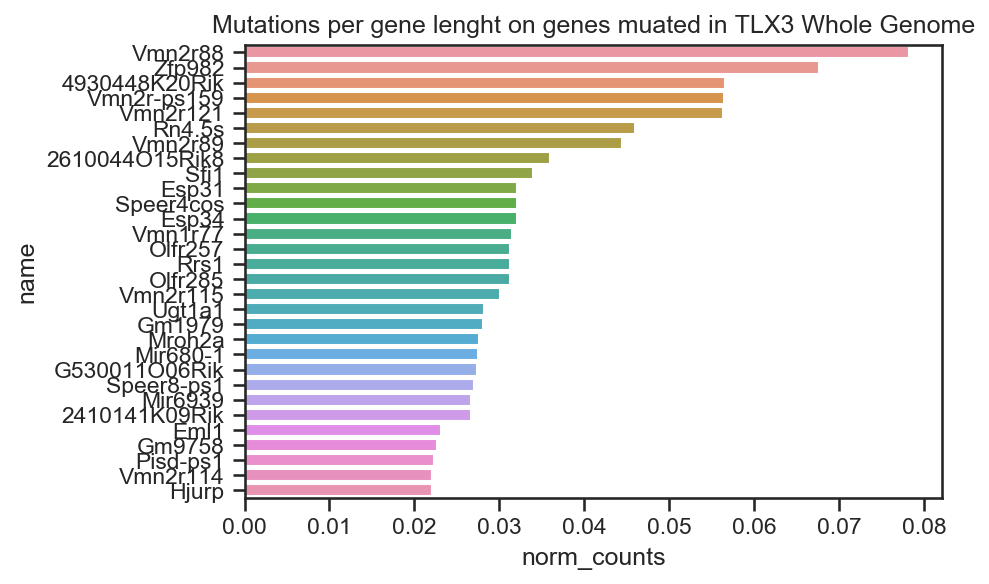

In [103]:
hd = tlx_mu_frq.head(30)

f, ax = plt.subplots()
sns.barplot(y=hd.index,
            x='norm_counts',
            ax= ax,
           data= hd)
ax.set_title('Mutations per gene lenght on genes muated in TLX3 Whole Genome')

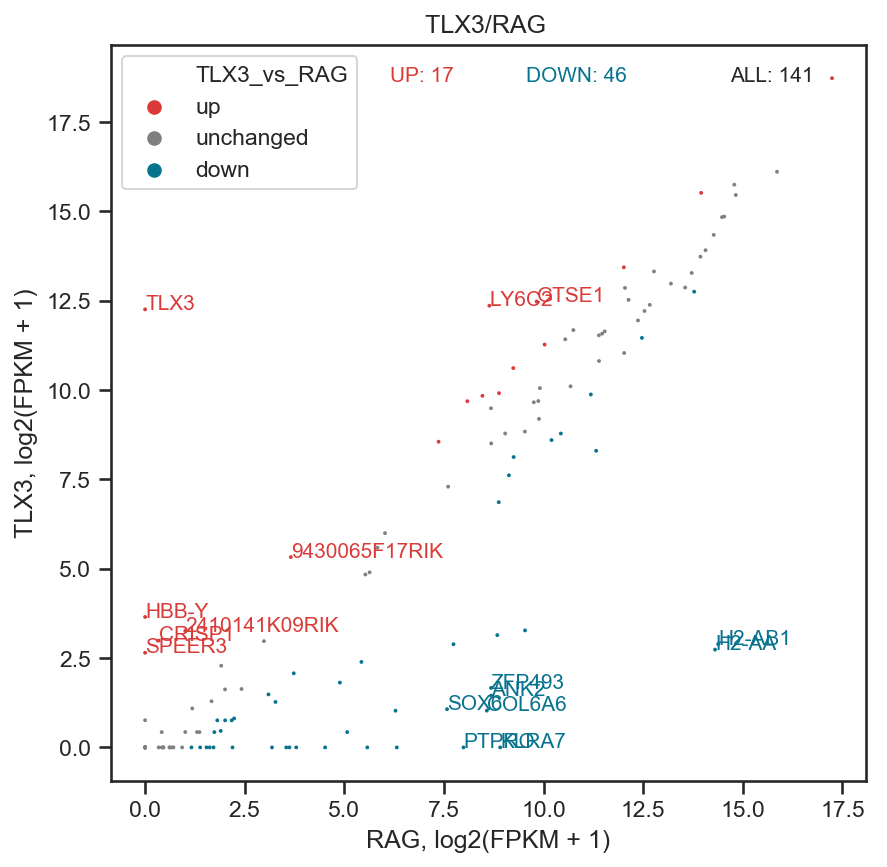

In [105]:
hd = tlx_mu_frq.head(200)
tbmut = tbv.iloc[tbv.index.isin(hd.index.str.upper())]
gr = rn.scatter_n(tbmut, A, B, classes, n_top=8)

Text(0.5,1,'Cluster TLX3/RAG')

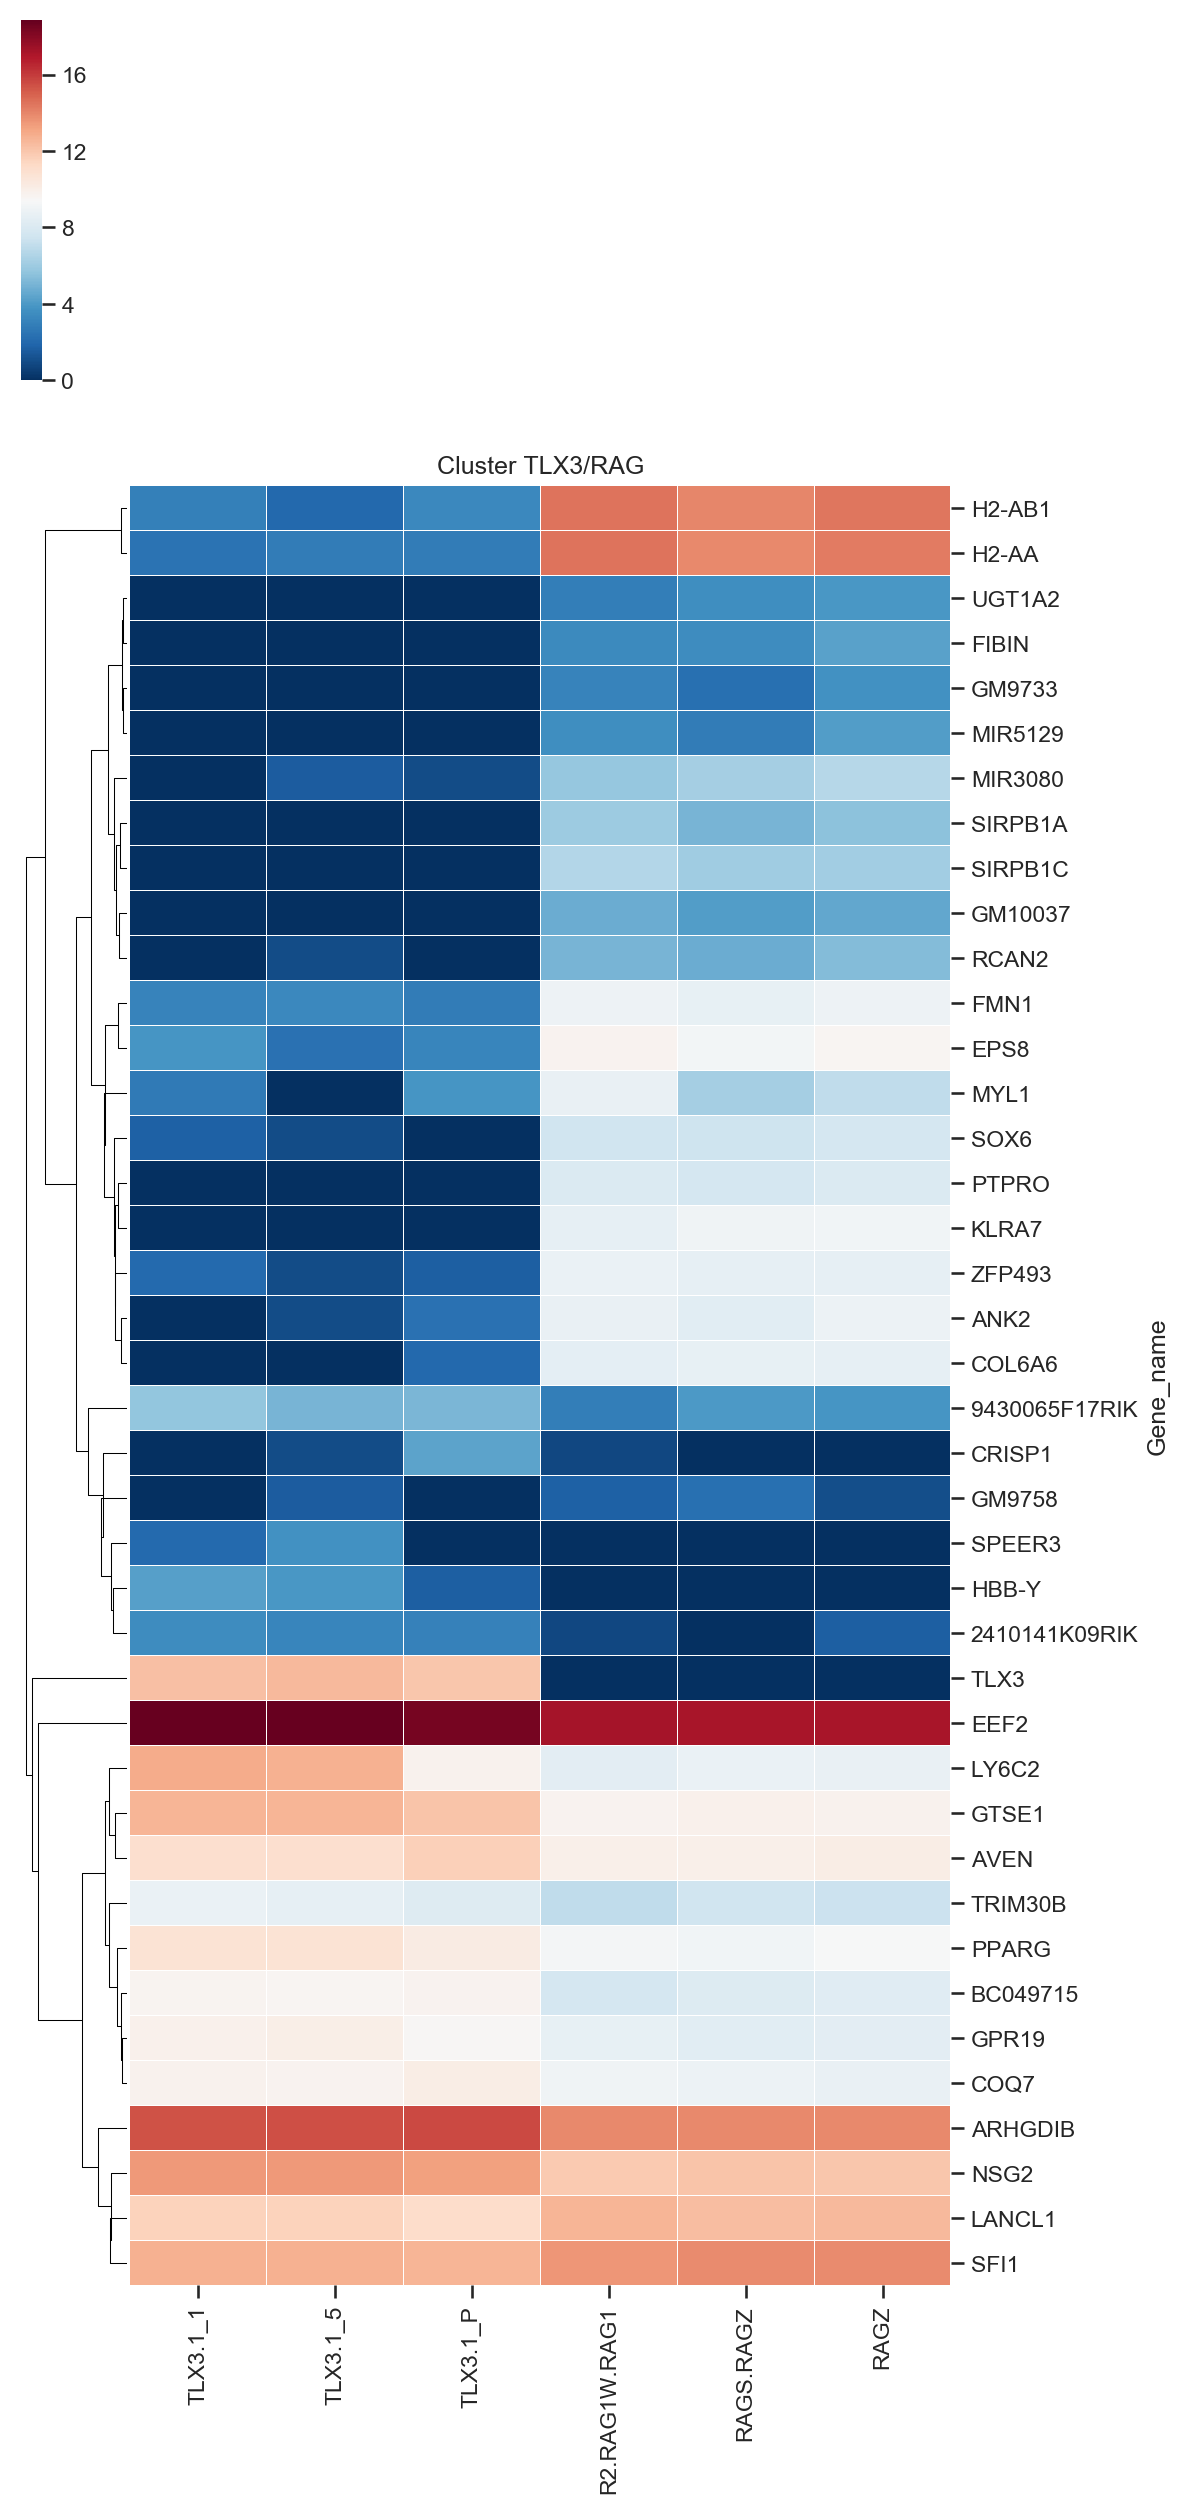

In [106]:
ntop=40
#tbmut = tbv.iloc[tbv.index.isin(gn_mut)]
gr = rn.cluster(tbmut, A, B, classes, n_top=ntop)
gr.ax_heatmap.set_title('Cluster '+A+'/'+B)

In [98]:
enr_Tmut = erl.enrich_gs(hd.index.str.upper(),gss, path_lib=join(DATADIR,'EnrichrLibs'))

GO_Biological_Process_2018 573
GO_Cellular_Component_2018 65
GO_Molecular_Function_2018 119
KEGG_2016 48
Reactome_2016 144


Text(0.5,1,'Genes muated in TLX3 Whole Genome')

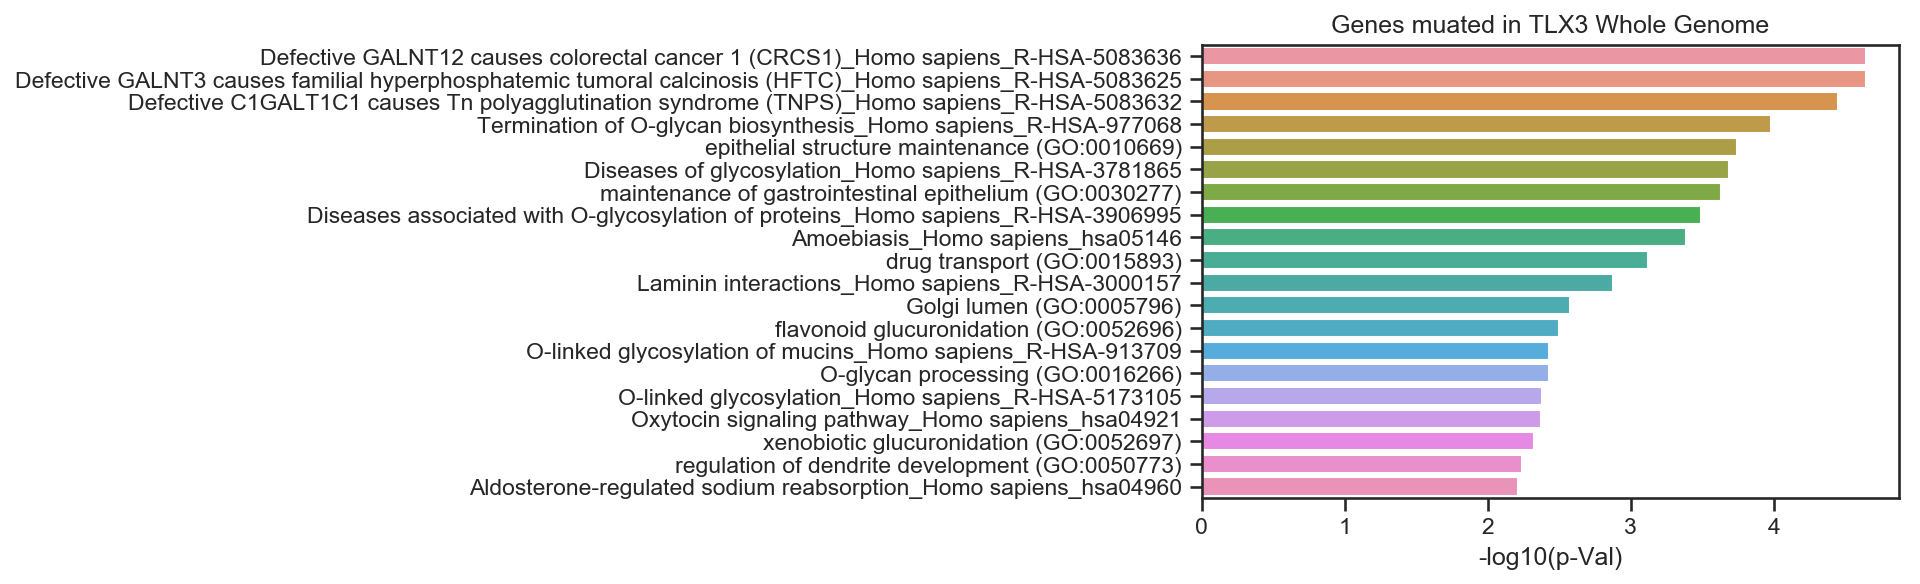

In [104]:
enr_Tmut.sort_values('p-Val', axis=0, inplace = True)
ds = enr_mut.head(20)

f, ax = plt.subplots()
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            #color="Red", 
            data = ds)
ax.set_title('Genes muated in TLX3 Whole Genome')